# Unsupervised Machine Learning: Product Segmentation


Here we use the K-Means unsupervised machine learning algorithm to group users by characteristics - popularity, price, nutrition, temperature and category.

K-means clustering is one of the simplest unsupervised machine learning algorithms where similar data points are grouped together in a cluster because of certain similarities. We can use this clustering method to discover underlying patterns. 

A number (k) of cluster centers are randomly assigned. For each data point, the distance between itself and the cluster centers are calculated and the data point is assigned to the nearest cluster center. This process is iterated until the mean of the cluster is stable.


## Data Import and Pre-Processing

In [1]:
#Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import string

from tqdm import tqdm_notebook as tqdm
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.feature_extraction import text 

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
#Import data
data = pd.read_csv('../raw/meals.csv')
orders = pd.read_csv('../raw/order_items.csv')

In [3]:
#Inspect data
data.sample()

,id,name,date,price,description,created_at,updated_at,recipe_id,serving,meal_id,...,sides,temperature,category,byline,price_excluding_gst,price_including_gst,feedback_score,is_archived,is_resale,premium_surcharge_per_pax
492,497,Beef Tenderloin Stroganoff,NaN,15.95,A timeless dish from the Old Cuisine of Russia...,2017-11-06 17:26:17.690816,2017-11-24 17:14:58.184560,447,NaN,BEEFNOFF,...,False,warm,highlight,"with turmeric spaghetti, sautéed red cabbage a...",14.91,15.95,NaN,True,False,NaN


### Remove outliers

In [4]:
#Reference 1.Descriptive_Statistics
#Replace value with $10 instead of $1000
data.loc[data.price == 1000,'price'] = 10

#Remove rows where price > 100, negative and 0 
data = data[(data.price<100)&(data.price>0)]

In [5]:
#Print number of items
ini_rows = data.shape[0]
ini_columns=data.shape[1]
print('We have {} records of transactions for {} unique items.'.format(ini_rows,data.id.nunique()))

We have 562 records of transactions for 562 unique items.


### Check for missing values

In [6]:
#Check missing values
data.isnull().sum().sort_values(ascending=False)

premium_surcharge_per_pax    562
restocking                   555
feedback_score               554
sold_out                     539
date                         527
daily                        369
serving                      347
drink                        347
byline                       266
temperature                   92
ingredients                   78
description                   57
macros                        57
meal_id                       53
price_excluding_gst           31
price_including_gst           27
category                       4
is_resale                      0
sides                          0
recipe_id                      0
updated_at                     0
created_at                     0
price                          0
is_archived                    0
name                           0
id                             0
dtype: int64

## Feature Engineering

### 1. Temperature

In [7]:
#Compute missing values in temperature (reference 1. Data_Cleaning under computing missing values in meals.csv)
censored

In [8]:
#Fill the rest of missing values with room temperature
data.temperature.fillna('room', inplace=True)

### 2. Category

In [9]:
#Inspect rows with missing values
data[data.category.isnull()]

,id,name,date,price,description,created_at,updated_at,recipe_id,serving,meal_id,...,sides,temperature,category,byline,price_excluding_gst,price_including_gst,feedback_score,is_archived,is_resale,premium_surcharge_per_pax
1,21,Thai Basil Pork Rice,NaN,10.95,NaN,2019-04-08 11:40:42.520491,2019-04-08 11:42:53.577584,21,NaN,BASILPORK,...,False,warm,NaN,NaN,10.23,10.95,NaN,True,False,NaN
35,23,Crab and Prawn Arrabiata Pasta,NaN,10.95,Having a crabby day? This mildly-spiced crab t...,2014-07-17 17:23:11.815966,2014-07-20 08:25:04.360053,28,False,B,...,False,room,NaN,NaN,NaN,NaN,NaN,True,False,NaN
41,10,Grilled Saba with Japanese Salad,2014-04-08,10.00,NaN,2014-07-09 23:40:49.360210,2015-02-13 18:06:34.144767,13,NaN,NaN,...,False,room,NaN,NaN,NaN,NaN,NaN,True,False,NaN
75,102,Chirashi-don,NaN,12.95,Time to warm up to our world of surprises. Ben...,2014-09-11 16:10:02.414600,2015-06-03 08:35:38.034138,21,False,CHIRASHI,...,False,chilled,NaN,NaN,NaN,NaN,NaN,True,False,NaN


In [10]:
#Fill missing values with main
data.category.fillna('main', inplace=True)

There are repeated categories such as 'main' and 'Main Course' which can be consolidated.

In [11]:
#Consolidating similiar categories
def consolidate_cat(x):
    if x == 'Main Course':
        return 'main'
    elif x == 'Appetiser':
        return 'side'
    elif x == 'Dessert':
        return 'dessert'
    elif x == 'partnership':
        return 'off_menu'
    else:
        return x

    #Call function
data.category = data.category.apply(lambda x : consolidate_cat(x))

#Print new categories
data.category.value_counts()

main          199
highlight     103
regular        63
side           59
drink          32
dessert        29
local          19
favorite       18
guilt-free     18
fresh          16
off_menu        6
Name: category, dtype: int64

### 3. Macros

In [12]:
#Fill missing values with 'none'
data.macros.fillna('none', inplace=True)

In [13]:
#Split in new dataframe
new = data.macros.str.split(', ', n=5, expand=True)

In [14]:
#Split name and values into seperate columns
def split_values_into_name_and_val(col):
    
    #Split name into new column and convert to lowercase
    new[str(col)+'_macros_name'] = new[col].str.split(':', n=2, expand=True)[0].fillna('None').map(lambda x: x.lower())
    
    #Split value into new column
    new[str(col)+'_macros_val'] = new[col].str.split(':', n=2, expand=True)[1]
    
    #Print component names present in each name column
    print(new[str(col)+'_macros_name'].unique())

#Call function for each column in new dataframe   
for col in new:
    split_values_into_name_and_val(col)

['none' 'coming soon' 'calories' ' calories' '-'
 'information included in christmas box' 'serving size']
['none' 'fat' 'protein' 'carbs' 'calories']
['none' 'carb' 'protein' 'fat']
['none' 'protein' 'carb' ' fat']
['none' 'protein']


In [15]:
#Start new columns to store values for each component
new['calories'] = 0
new['fat'] = 0
new['protein'] = 0
new['carb'] = 0

In [16]:
#Iterate through rows in new dataframe and allocate values into the right component columns
new.loc[new['0_macros_name'] == 'calories', 'calories'] = new.loc[new['0_macros_name'] == 'calories', '0_macros_val']
new.loc[new['0_macros_name'] == ' calories', 'calories'] = new.loc[new['0_macros_name'] == ' calories', '0_macros_val']

new.loc[new['1_macros_name'] == 'calories', 'calories'] = new.loc[new['1_macros_name'] == 'calories', '1_macros_val']
new.loc[new['1_macros_name'] == 'fat', 'fat'] = new.loc[new['1_macros_name'] == 'fat', '1_macros_val']
new.loc[new['1_macros_name'] == 'protein', 'protein'] = new.loc[new['1_macros_name'] == 'protein', '1_macros_val']
new.loc[new['1_macros_name'] == 'carbs', 'carb'] = new.loc[new['1_macros_name'] == 'carbs', '1_macros_val']

new.loc[new['2_macros_name'] == 'fat', 'fat'] = new.loc[new['2_macros_name'] == 'fat', '2_macros_val']
new.loc[new['2_macros_name'] == 'protein', 'protein'] = new.loc[new['2_macros_name'] == 'protein', '2_macros_val']
new.loc[new['2_macros_name'] == 'carb', 'carb'] = new.loc[new['2_macros_name'] == 'carb', '2_macros_val']

new.loc[new['3_macros_name'] == ' fat', 'fat'] = new.loc[new['3_macros_name'] == ' fat', '3_macros_val']
new.loc[new['3_macros_name'] == 'protein', 'protein'] = new.loc[new['3_macros_name'] == 'protein', '3_macros_val']
new.loc[new['3_macros_name'] == 'carb', 'carb'] = new.loc[new['3_macros_name'] == 'carb', '3_macros_val']

new.loc[new['4_macros_name'] == 'protein', 'protein'] = new.loc[new['4_macros_name'] == 'protein', '4_macros_val']

In [17]:
#Remove grams(g) from values in fat, protein and carb
cols = ['fat','protein','carb']
for i in cols:
    new[str(i)] = new[str(i)].apply(lambda x: str(x).split('g')[0])

In [18]:
#Convert to float type
for i in ['calories', 'fat','protein','carb']:
    new[i] = new[i].astype(float)

In [19]:
#Merge only component columns with original dataframe
data = pd.concat([data, new[['calories','fat','protein','carb']]],axis=1)

### 4. One Hot Encoding

In [20]:
#Get relevant data inputs
menu_features = data[['temperature','calories','fat','protein','carb','price','category','name','id']]

In [21]:
#One hot encode temperature and category information
df_temp = pd.get_dummies(menu_features.temperature)
df_cat = pd.get_dummies(menu_features.category)

In [22]:
#Merge dataframes
df = pd.concat([menu_features,df_cat,df_temp], axis=1)

#Print shape
df.shape

(562, 23)

### 5. Quantity

In [23]:
#Find number of items that were never bought
print('{} items are not found in transaction data.'.format(df[~df.id.isin(orders.item_id)].shape[0]))

93 items are not found in transaction data.


In [24]:
#Remove items not bought before
df = df[df.id.isin(orders.item_id)]

#Print shape
df.shape

(469, 23)

In [25]:
#For each item, find total number purchased
item_qty = pd.DataFrame(orders.groupby('item_id').quantity.sum()).reset_index()

#Add new column for total quantity purchased
df['quantity'] = 0
for item in df.id:
    df.loc[df.id==item,'quantity'] = item_qty.loc[item_qty.item_id == item,'quantity'].iloc[0]

## Modelling

In [26]:
#Define modelling dataset
X = df[['price','dessert', 'drink', 'favorite', 'fresh', 'guilt-free',
       'highlight', 'local', 'main', 'off_menu', 'regular', 'side', 'calories',
       'fat', 'protein', 'carb', 'chilled', 'room', 'warm','quantity']]
X.sample(5)

,price,dessert,drink,favorite,fresh,guilt-free,highlight,local,main,off_menu,regular,side,calories,fat,protein,carb,chilled,room,warm,quantity
194,11.95,0,0,0,0,0,0,1,0,0,0,0,572.0,10.0,49.0,71.0,0,0,1,1699.0
575,12.95,0,0,0,0,0,0,0,0,0,1,0,518.0,35.0,6.0,51.0,0,0,1,539.0
500,12.95,0,0,0,0,0,1,0,0,0,0,0,551.0,19.0,45.0,51.0,0,0,1,1076.0
208,3.50,0,0,0,0,0,0,0,0,0,0,1,219.0,18.0,6.0,10.0,0,0,1,236.0
30,5.50,0,1,0,0,0,0,0,0,0,0,0,32.0,0.1,0.1,7.8,1,0,0,405.0


In [27]:
#Scale modelling data 
ss = StandardScaler()
Xs = ss.fit_transform(X)

### Dimension Reduction Using PCA

Principal component analysis is a technique for feature extraction. It allows us to combine input features in a way that retains most information despite dropping some features.

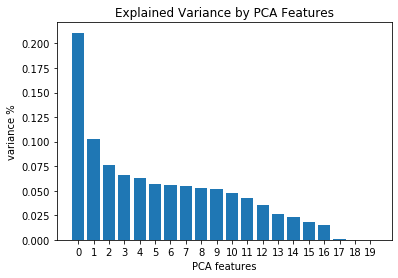

In [28]:
#Initialise model
pca = PCA()

#Fit model
principalComponents = pca.fit_transform(Xs)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.title('Explained Variance by PCA Features')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

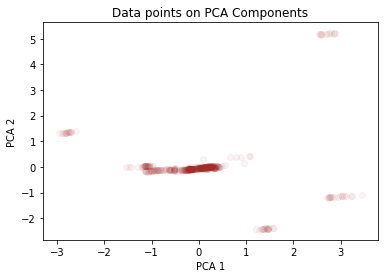

In [29]:
#Plot components
plt.scatter(PCA_components[8], PCA_components[9], alpha=.05, color='brown')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Data points on PCA Components')
plt.show()

### Unsupervised Clustering Using K-Means

The Elbow Curve is used to suggest an optimal K i.e. number of clusters. The model is evaluated on silhouette score (-1 to +1). It is a measure of how similar an object is to its own cluster compared to other clusters. The closer the value is to 1, the closer the data points are to its allocated cluster.

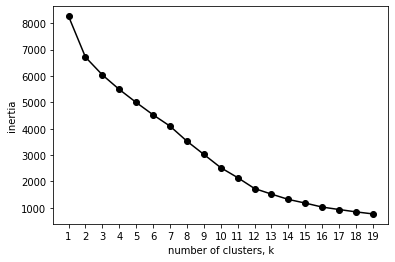

In [30]:
#Iterate through K of range 1 to 10
ks = range(1, 20)

#Empty list to store inertia
inertias = []

for k in ks:
    #Create a KMeans instance with k clusters: model
    knn_model = KMeans(n_clusters=k)
    
    #Fit model to samples
    knn_model.fit(PCA_components.iloc[:,:12])
    
    #Append the inertia to the list of inertias
    inertias.append(knn_model.inertia_)

#Plot elbow curve    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [31]:
#Initialise model
model = KMeans(n_clusters=12, random_state=42)

#Fit model
model.fit(PCA_components.iloc[:,:12])

#Get predictions
pred = model.labels_

#Add new column to store predictions
X['cluster'] = pred

In [32]:
#Calculate silhouette score
silhouette_score(Xs, pred, metric='euclidean')

0.45787283377634763

In [33]:
#Check representation
X.cluster.value_counts()

2     112
7     104
4      54
6      43
5      30
3      29
8      28
9      18
1      18
10     15
0      12
11      6
Name: cluster, dtype: int64

### Interpretation

In [34]:
X.groupby('cluster').mean()

,price,dessert,drink,favorite,fresh,guilt-free,highlight,local,main,off_menu,regular,side,calories,fat,protein,carb,chilled,room,warm,quantity
cluster,,,,,,,,,,,,,,,,,,,,
0,11.954167,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,410.500000,16.666667,29.583333,39.333333,0.583333,0.000000,0.416667,312.416667
1,12.665556,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,352.000000,10.500000,25.666667,41.944444,0.111111,0.000000,0.888889,2588.000000
2,11.779911,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.000000,519.062500,14.723214,34.839286,61.642857,0.401786,0.098214,0.500000,519.053571
3,10.600000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.551724,0.0,0.448276,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.103448,0.862069,115.758621
4,5.608333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000,242.129630,10.062963,16.868519,22.012963,0.574074,0.111111,0.314815,540.962963
5,6.045000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,105.356667,0.836667,2.336000,22.310000,0.866667,0.100000,0.033333,1901.533333
6,14.322093,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000,553.046512,19.662791,35.620930,64.162791,0.232558,0.000000,0.767442,5759.837209
7,14.690385,0.0,0.0,0.0,0.0,0.0,0.980769,0.0,0.000000,0.0,0.000000,0.019231,643.211538,24.673077,44.802885,62.605769,0.125000,0.000000,0.875000,939.951923
8,6.446429,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,385.714286,21.357143,7.428571,43.178571,0.928571,0.000000,0.071429,807.500000


In [35]:
#Add new column to store predictions in original dataframe
df['cluster']=pred

#Get user_ids of users belonging in each cluster
product_seg = df[['id','cluster']]

#Output data
product_seg.to_csv('../output/product_segmentation.csv',index=False)

### Explore Characteristics of Products by Clusters

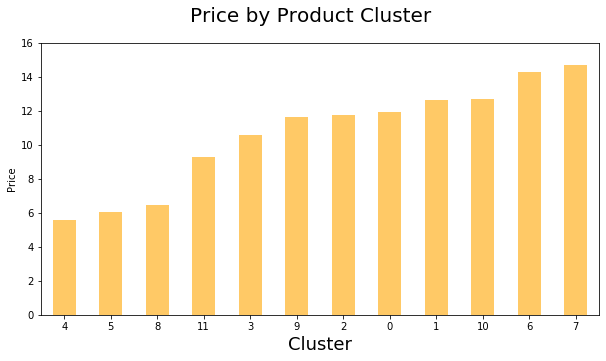

In [36]:
#Plot average price by product cluster
fig = plt.figure(figsize=(10,5))
X.groupby('cluster').mean().price.sort_values().plot('bar', color='orange', alpha=.6)
fig.suptitle('Price by Product Cluster', fontsize=20)
plt.xlabel('Cluster', fontsize=18)
plt.xticks(rotation=360)
plt.ylabel('Price', fontsize=10)
plt.yticks(np.arange(0,18,2))
plt.show()

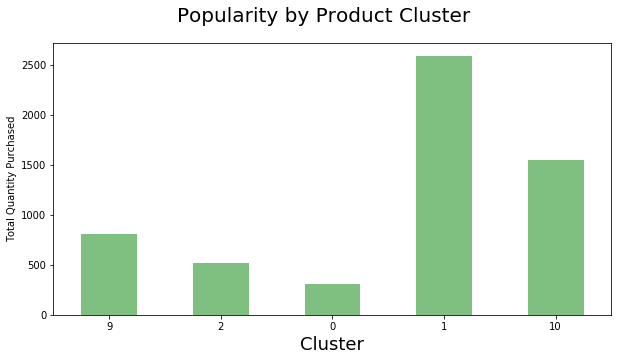

In [37]:
#Plot popularity of products in clusters with similiar pricing
fig = plt.figure(figsize=(10,5))
result = pd.DataFrame(X.groupby('cluster').mean())
result.iloc[[9,2,0,1,10]].quantity.plot('bar', color='green', alpha=.5)
fig.suptitle('Popularity by Product Cluster', fontsize=20)
plt.xlabel('Cluster', fontsize=18)
plt.xticks(rotation=360)
plt.ylabel('Total Quantity Purchased', fontsize=10)
# plt.yticks(np.arange(0,30,2))
plt.show()